In [2]:
import os
import json
import torch
import torch_geometric

from rdkit import Chem
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from util import MolFromGraphs, valid_checking
from data import load_dataset

from tqdm import tqdm
from rdkit import Chem, RDLogger

from gnn import load_trained_prediction

In [4]:
dataset_name = 'aids'
dataset = load_dataset(dataset_name)


In [5]:
dataset_name = 'aids'
summary_name = 'results/aids/runs/counterfactuals.pt'

def get_cand_and_cover(summary_name, dataset_name):
    summary = torch.load(summary_name)

    graphs = load_dataset(dataset_name)
    
    mapping_info = json.load(open('data/{}/raw/mapping_info.json'.format(dataset_name)))
    node_mapping = mapping_info['keep_node_mapping']

    preds = load_trained_prediction(dataset_name, device='cpu')
    preds = preds.cpu().numpy()
    input_graph_indices = np.array(range(len(preds)))[preds == 0]
    input_graphs = graphs[input_graph_indices.tolist()]

    valid_cand_mol = []
    for cand in summary['counterfactual_candidates']:
        graph_hasp = cand['graph_hash']
        graph = summary['graph_map'][graph_hasp]
        if valid_checking(graph, node_mapping):
            mol = MolFromGraphs(graph, node_mapping)
            covers = [input_graphs[idx] for idx in cand['input_graphs_covering_list'].coalesce().indices()[0]]
            ins = {
                'cand': mol,
                'cover': covers
            }
            valid_cand_mol.append(ins)

    return valid_cand_mol, node_mapping


In [6]:
valid_cand_mol, node_mapping = get_cand_and_cover(summary_name, dataset_name)

[01:01:18] Explicit valence for atom # 9 F, 2, is greater than permitted
[01:01:18] Explicit valence for atom # 4 N, 4, is greater than permitted
[01:01:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[01:01:18] Explicit valence for atom # 9 N, 5, is greater than permitted
[01:01:18] Explicit valence for atom # 10 O, 3, is greater than permitted
[01:01:18] Explicit valence for atom # 3 O, 3, is greater than permitted
[01:01:18] Explicit valence for atom # 4 F, 2, is greater than permitted
[01:01:18] Explicit valence for atom # 8 N, 4, is greater than permitted
[01:01:18] Explicit valence for atom # 7 Br, 2, is greater than permitted
[01:01:18] Explicit valence for atom # 9 Cl, 4, is greater than permitted
[01:01:18] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:01:18] Explicit valence for atom # 10 Cl, 5, is greater than permitted
[01:01:18] Explicit valence for atom # 10 Na, 2, is greater than permitted
[01:01:18] Explicit valence for atom # 2 C, 

In [7]:
def show_mol(mol, ax=None):
    im = Chem.Draw.MolToImage(mol)
    if ax is None:
        plt.axis("off")
        plt.imshow(im)
    else:
        ax.axis("off")
        ax.imshow(im)

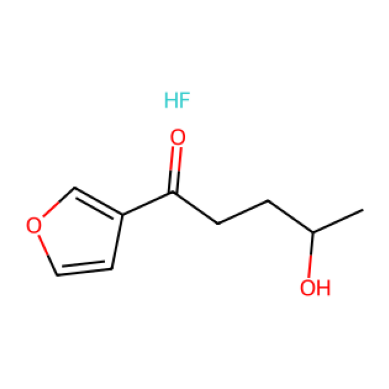

In [8]:
show_mol(valid_cand_mol[1]['cand'])

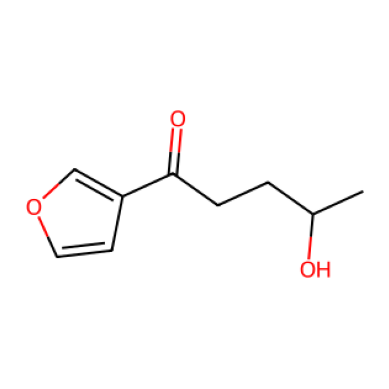

In [9]:
show_mol(MolFromGraphs(valid_cand_mol[1]['cover'][0], node_mapping))

In [10]:
def print_cand(cand_idx):
    cover_num = len(valid_cand_mol[cand_idx]['cover'])
    print(cover_num)

    nrow, ncol = 2, max(cover_num, 2)
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol)

    for i in range(nrow):
        for j in range(ncol):
            ax[i][j].axis("off")
            if i == 0:
                if j == 0:
                    show_mol(valid_cand_mol[cand_idx]['cand'], ax=ax[i][j])
                else:
                    continue
            else:
                idx = j
                if idx >= cover_num:
                    break
                else:
                    cover_mol = MolFromGraphs(valid_cand_mol[cand_idx]['cover'][idx], node_mapping)
                    show_mol(cover_mol, ax=ax[i][j])

2


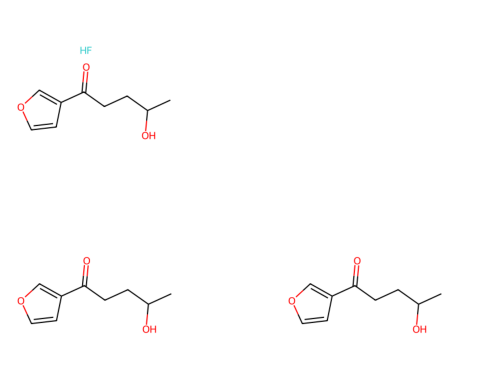

In [11]:
print_cand(1)

1


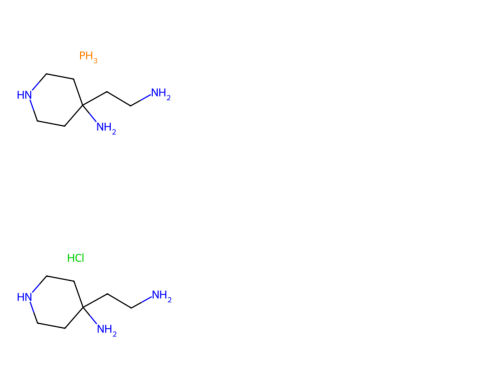

In [12]:
print_cand(2)

1


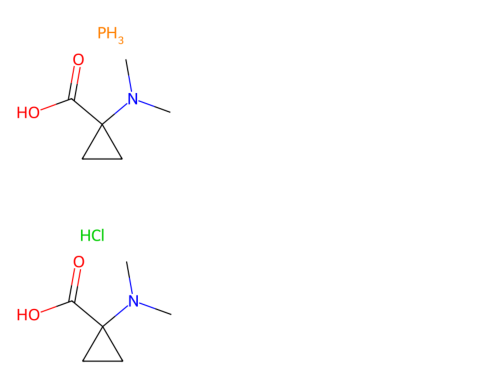

In [13]:
print_cand(3)

2


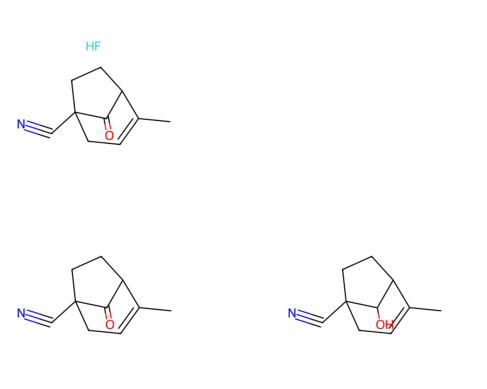

In [14]:
print_cand(4)

1


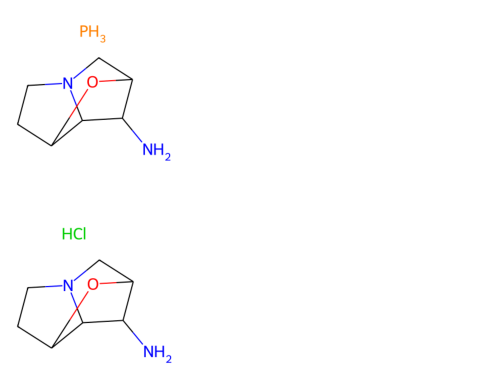

In [15]:
print_cand(5)

1


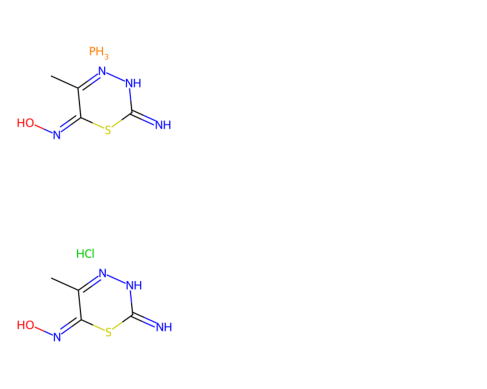

In [16]:
print_cand(6)